# Facial Expressoin Recognition with Feed Forward Neural Network

## Imports

In [39]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [40]:
project_name = '003facialexpressorecogfeedforwardapproach'

## Dataset

In [41]:
data_dir = '../input/facial-expression-recog-image-ver-of-fercdataset/Dataset'
classes = os.listdir(data_dir + '/train')

No. of training images of each class in training set:-

In [42]:
for i in classes:
    var_files = os.listdir(data_dir + '/train/' + i)
    print(i,': ',len(var_files))

fear :  4593
surprise :  3586
sadness :  5483
disgust :  493
anger :  4462
happiness :  8110
neutral :  5572


No. of training images of each class in test set:-

In [43]:
for i in classes:
    var_files = os.listdir(data_dir + '/test/' + i)
    print(i,': ',len(var_files))

fear :  528
surprise :  416
sadness :  594
disgust :  55
anger :  491
happiness :  879
neutral :  626


Creating the `dataset` variable

In [44]:
dataset = ImageFolder(
    data_dir + '/train', 
    transform = ToTensor()
                     )

In [45]:
dataset

Dataset ImageFolder
    Number of datapoints: 32298
    Root location: ../input/facial-expression-recog-image-ver-of-fercdataset/Dataset/train
    StandardTransform
Transform: ToTensor()

Lets have a look to the tensors and the labels

In [46]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 48, 48]) 0


tensor([[[0.1529, 0.1725, 0.1608,  ..., 0.4745, 0.5255, 0.6078],
         [0.1451, 0.1569, 0.1529,  ..., 0.4824, 0.5333, 0.6196],
         [0.1216, 0.1216, 0.1412,  ..., 0.4824, 0.5529, 0.6353],
         ...,
         [0.1412, 0.1490, 0.1451,  ..., 0.4980, 0.5294, 0.5255],
         [0.1490, 0.1529, 0.1647,  ..., 0.4314, 0.4549, 0.4745],
         [0.1529, 0.1569, 0.1647,  ..., 0.4667, 0.5255, 0.5529]],

        [[0.1529, 0.1725, 0.1608,  ..., 0.4745, 0.5255, 0.6078],
         [0.1451, 0.1569, 0.1529,  ..., 0.4824, 0.5333, 0.6196],
         [0.1216, 0.1216, 0.1412,  ..., 0.4824, 0.5529, 0.6353],
         ...,
         [0.1412, 0.1490, 0.1451,  ..., 0.4980, 0.5294, 0.5255],
         [0.1490, 0.1529, 0.1647,  ..., 0.4314, 0.4549, 0.4745],
         [0.1529, 0.1569, 0.1647,  ..., 0.4667, 0.5255, 0.5529]],

        [[0.1529, 0.1725, 0.1608,  ..., 0.4745, 0.5255, 0.6078],
         [0.1451, 0.1569, 0.1529,  ..., 0.4824, 0.5333, 0.6196],
         [0.1216, 0.1216, 0.1412,  ..., 0.4824, 0.5529, 0.

In [47]:
print(dataset.classes)

['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


In [48]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  fear (2)


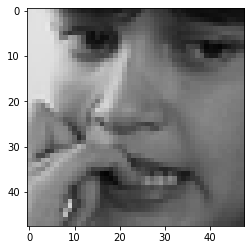

In [49]:
show_example(*dataset[9050])

In [50]:
val_size = int(0.1*32298) # 10% of the dataset as validatoin set
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset,[train_size, val_size])
test_ds = ImageFolder(data_dir + '/test', transform = ToTensor())

In [51]:
print(train_ds)
print(val_ds)
print(test_ds)

Dataset ImageFolder
    Number of datapoints: 3589
    Root location: ../input/facial-expression-recog-image-ver-of-fercdataset/Dataset/test
    StandardTransform
Transform: ToTensor()


## Data Loader

In [52]:
batch_size = 64

In [53]:
train_loader = DataLoader(
                          train_ds, 
                          batch_size, 
                          shuffle=True, 
                          num_workers=4, 
                          pin_memory=True
                         )

val_loader = DataLoader(
                        val_ds, 
                        batch_size*2, 
                        num_workers=4, 
                        pin_memory=True
                       )

images.shape: torch.Size([64, 3, 48, 48])


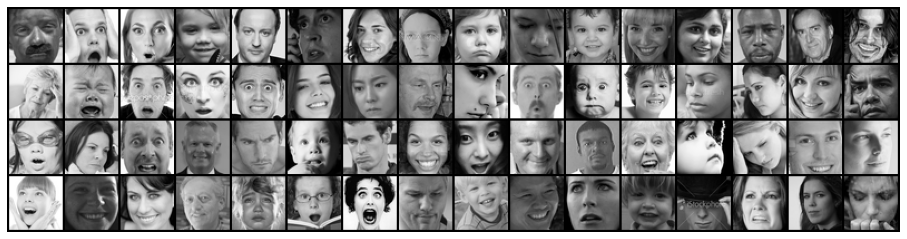

In [54]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Model

In [55]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

So to improve upon Logistic regression we will implement Neural netwrok.

And this is where neural network comes into play after this our model becomes a neural network with `no. of layer` hidden layer.

In [56]:
class Facial_Recog_Model(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 1024)
        # hidden layer 2
        self.linear2 = nn.Linear(1024, 512)
        # hidden layer 3
        self.linear3 = nn.Linear(512,256)
        # hidden Layer 4
        self.linear4 = nn.Linear(256, 128)
        # hidden Layer 5
        self.linear5 = nn.Linear(128, 64)
        # output layer
        self.linear6 = nn.Linear(64, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)

        # Get intermediate outputs using hidden layer
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)

        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)

        # Get intermediate outputs using hidde layer 3
        out = self.linear3(out)
        # Apply activation function
        out = F.relu(out)

        # Get intermediate outputs using hidde layer 4
        out = self.linear4(out)
        # Apply activation function
        out = F.relu(out)
        
        # Get intermediate outputs using hidde layer 5
        out = self.linear5(out)
        # Apply activation function
        out = F.relu(out)

        # Get predictions using output layer
        out = self.linear6(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [57]:
input_size = 48*48*3
num_classes = 7

In [58]:
model = Facial_Recog_Model(input_size, out_size = num_classes)

In [59]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 1.9450169801712036
outputs.shape :  torch.Size([64, 7])
Sample outputs :
 tensor([[ 0.0714, -0.0036,  0.0639,  0.0194, -0.0406,  0.0564,  0.0759],
        [ 0.0709, -0.0045,  0.0665,  0.0179, -0.0367,  0.0563,  0.0789]])


## Using a GPU

In [60]:
torch.cuda.is_available()

True

In [61]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [62]:
device = get_default_device()
device

device(type='cuda')

Moving all our data and model to a choosen devise

In [63]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [64]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([64, 3, 48, 48])
cuda:0


In [65]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [66]:
train_loader = DeviceDataLoader(
                                train_loader, 
                                device
                               )
val_loader = DeviceDataLoader(
                              val_loader, 
                              device
                             )

In [67]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([4, 0, 2, 4, 6, 4, 3, 3, 0, 3, 5, 4, 3, 2, 6, 3, 4, 2, 2, 3, 3, 4, 3, 5,
        4, 0, 3, 4, 6, 6, 2, 3, 2, 4, 4, 2, 5, 5, 0, 6, 3, 4, 4, 6, 2, 0, 3, 2,
        2, 4, 6, 0, 6, 2, 5, 0, 2, 3, 4, 4, 3, 5, 4, 2, 3, 2, 3, 4, 3, 3, 4, 5,
        3, 5, 4, 0, 5, 5, 2, 5, 3, 5, 5, 2, 4, 3, 6, 3, 3, 4, 5, 3, 4, 3, 6, 5,
        2, 4, 3, 3, 3, 3, 0, 5, 3, 6, 0, 3, 4, 2, 3, 5, 5, 4, 3, 3, 2, 5, 3, 6,
        3, 5, 6, 3, 3, 3, 2, 0], device='cuda:0')


## Defining the training function

In [68]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [69]:
# Model (on GPU)
model = Facial_Recog_Model(input_size, out_size = num_classes)
to_device(model, device)

Facial_Recog_Model(
  (linear1): Linear(in_features=6912, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=128, bias=True)
  (linear5): Linear(in_features=128, out_features=64, bias=True)
  (linear6): Linear(in_features=64, out_features=7, bias=True)
)

In [70]:
for t in model.parameters():
    print(t.shape)

torch.Size([1024, 6912])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([256, 512])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([7, 64])
torch.Size([7])


In [71]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.9420872926712036, 'val_acc': 0.18216387927532196}]

## Training the Model

In [72]:
history += fit(10, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7934, val_acc: 0.2593
Epoch [1], val_loss: 1.8323, val_acc: 0.2590
Epoch [2], val_loss: 1.8045, val_acc: 0.2828
Epoch [3], val_loss: 1.6797, val_acc: 0.3458
Epoch [4], val_loss: 1.8180, val_acc: 0.2319
Epoch [5], val_loss: 1.6884, val_acc: 0.3450
Epoch [6], val_loss: 1.7115, val_acc: 0.3363
Epoch [7], val_loss: 1.6805, val_acc: 0.3488
Epoch [8], val_loss: 1.8746, val_acc: 0.2935
Epoch [9], val_loss: 1.7159, val_acc: 0.2895


In [73]:
history += fit(15, 0.03, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6672, val_acc: 0.3430
Epoch [1], val_loss: 1.5708, val_acc: 0.3936
Epoch [2], val_loss: 1.7283, val_acc: 0.3543
Epoch [3], val_loss: 1.6664, val_acc: 0.3592
Epoch [4], val_loss: 1.7742, val_acc: 0.2860
Epoch [5], val_loss: 1.7711, val_acc: 0.3265
Epoch [6], val_loss: 1.7104, val_acc: 0.3460
Epoch [7], val_loss: 1.6290, val_acc: 0.3823
Epoch [8], val_loss: 1.6736, val_acc: 0.3656
Epoch [9], val_loss: 1.5560, val_acc: 0.3980
Epoch [10], val_loss: 1.5411, val_acc: 0.4074
Epoch [11], val_loss: 1.6122, val_acc: 0.3767
Epoch [12], val_loss: 1.6915, val_acc: 0.3370
Epoch [13], val_loss: 1.6657, val_acc: 0.3567
Epoch [14], val_loss: 1.5294, val_acc: 0.4059


In [74]:
history += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6328, val_acc: 0.3384
Epoch [1], val_loss: 1.5934, val_acc: 0.3956
Epoch [2], val_loss: 1.5345, val_acc: 0.4152
Epoch [3], val_loss: 1.4975, val_acc: 0.4308
Epoch [4], val_loss: 1.5607, val_acc: 0.4050
Epoch [5], val_loss: 1.5485, val_acc: 0.4136
Epoch [6], val_loss: 1.5829, val_acc: 0.3974
Epoch [7], val_loss: 1.5676, val_acc: 0.4049
Epoch [8], val_loss: 1.6250, val_acc: 0.3990
Epoch [9], val_loss: 1.5928, val_acc: 0.3776
Epoch [10], val_loss: 1.5560, val_acc: 0.4121
Epoch [11], val_loss: 1.5888, val_acc: 0.3978
Epoch [12], val_loss: 1.6544, val_acc: 0.4118
Epoch [13], val_loss: 1.7689, val_acc: 0.3673
Epoch [14], val_loss: 1.5810, val_acc: 0.4079
Epoch [15], val_loss: 1.6025, val_acc: 0.3982
Epoch [16], val_loss: 1.9518, val_acc: 0.3088
Epoch [17], val_loss: 1.5322, val_acc: 0.4282
Epoch [18], val_loss: 1.6914, val_acc: 0.4186
Epoch [19], val_loss: 1.8231, val_acc: 0.3924


In [75]:
history += fit(20, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4656, val_acc: 0.4650
Epoch [1], val_loss: 1.4748, val_acc: 0.4623
Epoch [2], val_loss: 1.4784, val_acc: 0.4670
Epoch [3], val_loss: 1.4827, val_acc: 0.4608
Epoch [4], val_loss: 1.5069, val_acc: 0.4550
Epoch [5], val_loss: 1.4889, val_acc: 0.4566
Epoch [6], val_loss: 1.5014, val_acc: 0.4579
Epoch [7], val_loss: 1.5064, val_acc: 0.4688
Epoch [8], val_loss: 1.5131, val_acc: 0.4572
Epoch [9], val_loss: 1.5113, val_acc: 0.4683
Epoch [10], val_loss: 1.5321, val_acc: 0.4661
Epoch [11], val_loss: 1.5256, val_acc: 0.4621
Epoch [12], val_loss: 1.5359, val_acc: 0.4596
Epoch [13], val_loss: 1.5315, val_acc: 0.4644
Epoch [14], val_loss: 1.5515, val_acc: 0.4526
Epoch [15], val_loss: 1.5506, val_acc: 0.4573
Epoch [16], val_loss: 1.5667, val_acc: 0.4547
Epoch [17], val_loss: 1.5665, val_acc: 0.4547
Epoch [18], val_loss: 1.5664, val_acc: 0.4655
Epoch [19], val_loss: 1.6101, val_acc: 0.4691


## Plotting functions

In [76]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x', color='red')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

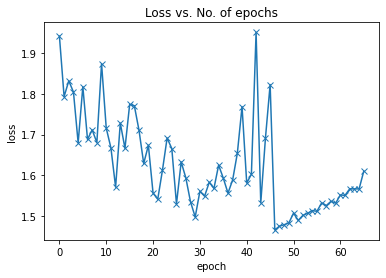

In [77]:
plot_losses(history)

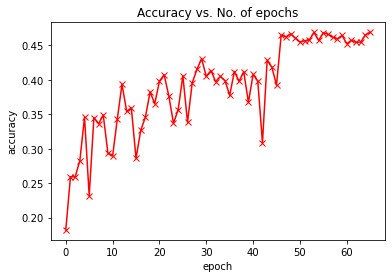

In [78]:
plot_accuracies(history)

### Final Evaluation

In [79]:
evaluate(model, val_loader)

{'val_loss': 1.6100525856018066, 'val_acc': 0.46911266446113586}

In [80]:
Stop here

SyntaxError: invalid syntax (<ipython-input-80-bc113f3dc93b>, line 1)

## Hyper params ad other details

In [81]:
val_loss = history[-1]['val_loss']
val_acc = history[-1]['val_acc']
num_epochs = [10, 15, 20, 20]
lr = [0.05, 0.03, 0.01, 0.001]
arch = "7 layers (1024, 512, 256, 128, 64, 7)"

## Commiting to Jovian

In [82]:
!pip install jovian --upgrade -q

In [83]:
import jovian

<IPython.core.display.Javascript object>

In [84]:
#jovian.commit(project=project_name, environment = None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/manishshah120/003facialexpressorecogfeedforwardapproach


<IPython.core.display.Javascript object>

In [85]:
jovian.log_dataset(dataset_url='https://www.kaggle.com/manishshah120/facial-expression-recog-image-ver-of-fercdataset', val_size=val_size, train_size = train_size)

[jovian] Dataset logged.


In [86]:
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'lr': lr,
    'arch': arch
})

[jovian] Hyperparams logged.


In [87]:
jovian.log_metrics(val_loss=val_loss, val_acc=val_acc)

[jovian] Metrics logged.


In [88]:
jovian.commit(project = project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/manishshah120/003facialexpressorecogfeedforwardapproach


<IPython.core.display.Javascript object>